### Beispiele zum g-h-Filter 
11.10.2022, S. Mack  
  
> Der Begriff *g-h-Filter* steht nicht für einen konkreten Filter sondern für eine *Klasse von Filtern*. Die g-h-Filter bestehen aus mindestens elf Unterklassen. Eine davon ist der Kalman-Filter.  

Die Unterklassen unterscheiden sich in der Auswahl der beiden Skalierungsfaktoren $g$ und $h$. Die Faktoren sind teils Konstanten, teils ändern sie sich dynamisch. Bei letzterem Ansatz gibt es Filter, die Werte für $g$ und $h$ auf ein bestimmtes Intervall beschränken oder über eine Funktion $g = f(h)$ von einander abhängig machen.  
Das Besondere am Kalman-Filter, wie in den folgenden Notebooks gezeigt wird, ist die Normalverteilung als grundlegende Statistik für die Mess- und Vorhersagewerte. Die Skalierungsfaktoren $g$ und $h$ berechnen sich hier über die Standardabweichung, also über die Unsicherheit des Vorhersage- bzw. Messwerts.  

**Nachfolgend wird ein "Basismodell" des g-h-Filters mit vorgegebenen konstanten Skalierungsfaktoren anhand von Beispielen näher betrachtet.**    
Dafür müssen zunächst Funktionen für einen generischen g-h-Filteralgorithmus für eine Messwertsimulation sowie für eine Visualisierung erstellt werden. Anschließend werden verschiedene Messwertverläufe simuliert und diese dann mit einem g-h-Filter "gefiltert". Hier liegt der Schwerpunkt auf dem Einfluss der Filterparameter $g$ und $h$.  
Der einfachste Filter für verrauschte Messdaten ist die gleitende Mittelwertbildung: Der g-h-Filter besitzt hier den großen Vorteil einer deutlich kleineren Signalverzögerung, wie Beispiele am Ende dieses Jupyter-Notebooks zeigen.

In [1]:
#to render plots inside this notebook
%matplotlib inline
# import of python packages
import matplotlib.pyplot as plt
import numpy as np

## Generischer Algorithmus des g-h-Filters
Der g-h-Filter des vorherigen Jupyter-Notebooks wurde spezifisch für das Roboterfahrzeug entwickelt, welches entlang der Wand fährt und dabei Abstandsmessungen vornimmt. Nun wird der selbe Algorithmus allgemeingültig in Quellcode verfasst.  
Er wird in Form einer Funktion ``g_h_filter()`` erstellt, der die im Pythonkommentar aufgeführten Variablen übergeben werden. Diese Funktion gibt einen ``NumPy``-Array mit den Schätzwerten der Zustandsgrößen zurück:

```python
def g_h_filter(data, x0, dx, g, h, dt):
    """
    Performs g-h filter on 1 state variable with a fixed g and h.
    Returns NumPy array with state estimates for 'x' only, not for 'dx'. 
    'data' contains the data to be filtered.
    'x0' is the initial value for our state variable
    'dx0' is the initial change rate for our state variable
    'g' is the g-h's g scale factor
    'h' is the g-h's h scale factor
    'dt' is the length of the time step 
    """
```

Für das Roboterfahrzeug entsprechen die oben aufgeführten Variablen den folgenden Werten:  
* `data` steht für die Folge der Abstandsmesswerte, 
* `x0` für den Startwert des Abstands, 
* `dx` für den Startwert der Abstandsänderung, 
* `g` bzw. `h` für die Skalierungsfaktoren `meas_scale` bzw. `gain_scale`. 
* Das Ausgabe-Array steht für die Folge der Schätzwerte des Abstands.

### Die Funktion "g_h_Filter()"
Ausgangspunkt ist der letzte Quellcode des vorherigen Jupyter-Notebooks zum g-h-Filter: Dort werden `initial_guess_meas` durch `x0`, `initial_guess_gain` durch `dx`, `meas_scale` durch `g` und `gain_scale` durch `h` ersetzt. Im Vorhersageschritt wird das Zeitinkrement `dt` eingeführt. Die Variable `measurement` wird jetzt in `z`, `x_pred` und `x_est` unterschieden. ``x_est`` ist der Korrekturwert, also der Schätzwert für die nächste Iteration (engl. estimate).

In [2]:
def g_h_filter(data, x0, dx0, g, h, dt=1.):
    x_est = x0
    dx = dx0
    results = []
    for z in data: # data contains the measurements of state values
        # prediction step
        x_pred = x_est + (dx*dt)
        # update step
        residual = z - x_pred
        dx = dx + h * (residual) / dt # new estimate of change rate
        x_est = x_pred + g * residual # new estimate of state variable value
        results.append(x_est)
    return np.array(results)

### Plotfunktion zur Darstellung der Mess- und Filterwerte  
Es wird eine Plotfunktion für den Mess- und Schätzwertverlauf ``plot_x_est()`` erstellt, um bei den folgenden Beispielen den Messwerte- und Filterwerteverlauf darzustellen.  
Damit wird die neue Filterfunktion ``g_h_filter()`` auf die Abstandsmesswerte des Roboterfahrzeugs aus dem vorherigen Jupyter-Notebook nochmals angewendet. Über den Vergleich der beiden Ausgabeplots des vorherigen und aktuellen Jupyter-Notebooks wird verifiziert, dass ``g_h_filter()`` identische, also richtigen Ausgabewerte liefert.

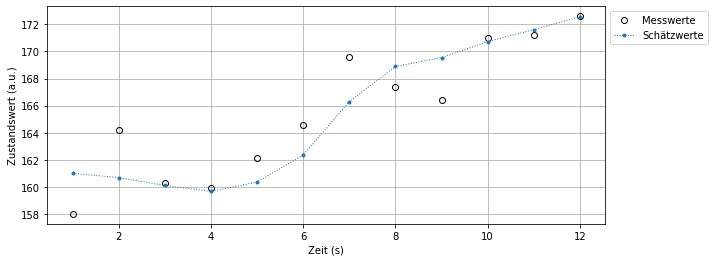

In [3]:
# "state variables" corresponds to "measurements" and "state estimates" to "filtered data" just a naming issue
def plot_x_est(state_var, state_est):
    plt.figure(figsize=(10,4))
    n = len(state_var)
    time = range(1,n+1)
    var, = plt.plot(time, state_var, color='k', mfc='None', marker = 'o', linestyle='None') # mfc = hollow markers
    est, = plt.plot(time, state_est, marker = 'o', linestyle=':', linewidth = 1, markersize=3)
    plt.legend([var, est], ['Messwerte', 'Schätzwerte'], loc="upper left", bbox_to_anchor=(1,1))
    plt.xlabel('Zeit (s)')
    plt.ylabel('Zustandswert (a.u.)')
    plt.grid()
    
measurements = [158.0, 164.2, 160.3, 159.9, 162.1, 164.6, 169.6, 167.4, 166.4, 171.0, 171.2, 172.6]
filtered_data = g_h_filter(data=measurements, x0=164., dx0=-1., g=4./10, h=1./3, dt=1.)
plot_x_est(measurements, filtered_data)

Das Ergebnis ist identisch zum letzten Plot des vorherigen Jupyter-Notebooks. Dort war lediglich zur Zeit $t = 0$ noch der Startwert $\hat x_0$ geplottet. Aber streng genommen ist dieser geratene Wert kein Schätzwert.  
Mit den beiden Funktionen ``g_h_filter()`` und ``plot_x_est()`` wird in den nächsten Abschnitten der Einfluss der Skalierungsfaktoren auf die Filtereigenschaften untersucht.  
Zunächst wird jedoch eine weitere Funktion benötigt, die verrauschte Messwerte für die Simulation erzeugt.

## Erzeugung verrauschter linear ansteigender Messwerte für die Simulation
### Die Gaußsche Normalverteilung

Die Funktion `numpy.random.randn()` aus dem ``NumPy``-Package gibt normalverteilte Zufallswerte zurück, die einen Erwartungswert von 0 und eine *Standardabweichung von 1* besitzen.  
Im Plot unten ist eine sogenannte *Stichprobe* von 3000 mit `randn()` erzeugten Zufallswerten dargestellt, jeder Punkt entspricht einem Zufallswert.  
In dem Bereich $\pm$ 2, also $\pm$ 2 mal die Standardabweichung liegen die bekannten 95,45 % aller Zufallswerte.

Text(0.5, 0, 'Nummer in Stichprobe')

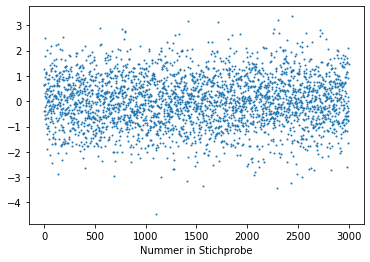

In [4]:
from numpy.random import randn
#np.random.seed(100) #makes the random numbers predictable for reproducible simulations

plt.plot([randn() for _ in range(3000)], marker='o', markersize=1, linestyle='None');
plt.xlabel('Nummer in Stichprobe')

### Funktion zur Generierung eines linearen Messwertverlaufs
Die benötigte Funktion soll Messdaten erzeugen, die mit weißem Rauschen überlagert sind. "Weiß" bedeutet in diesem Zusammenhang, dass das Rauschen unkorreliert ist, also keine dominanten Frequenzanteile besitzt. Das Rauschen ist mittelwertfrei. Seine Intensität wird über dessen Standardabweichung quantifiziert.  
Wie oben vorgestellt kann mit der Funktion  ``randn()`` ein solches Rauschen erzeugt werden: ``randn()`` gibt Werte zurück, die der Standardnormalverteilung (gaußsche Normalverteilung mit Erwartungswert 0 und Standardabweichung von 1) gehorchen.  
Die Funktion zu Messwertgenerierung ``gen_data()`` erhält als Input einen Startwert, eine Steigung pro Sample, die Anzahl der Samples sowie die Standardabweichung des Rauschens, welches überlagert wird.  
Der wahre (nicht dargestellte) Verlauf der Abstandswerte ist streng linear ohne Rauschen - genau so wie die Abstandswerte eines idealen Fahrzeugs, welches exakt geradlinig schräg von der Wand weg fährt.  

In folgendem Quellcode wird zuerst ein verrauschter Messwertverlauf simuliert und anschließend darauf ein g-h-Filter angewendet.

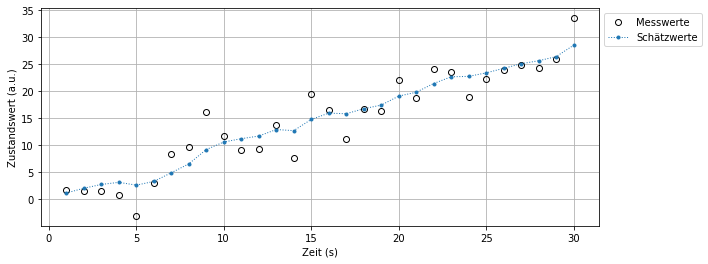

In [5]:
def gen_data(x0, dx, num_data, st_dev):
    # dx: average slope of the noise data to be generated
    return [x0 + dx*i + randn()*st_dev for i in range(num_data)]

measurements = gen_data(x0=0, dx=1, num_data=30, st_dev=3)
filtered_data = g_h_filter(data=measurements, x0=0., dx0=1., g=.2, h=0.02, dt=1.)
plot_x_est(measurements, filtered_data)

*Achtung:* Wenn der Quellcode oben erneut ausgeführt wird, dann fließen auch wieder neue Zufallszahlen ein. D.h. der Plot ändert sich, obwohl die Parameter nicht geändert wurden.  
Eine realistische Standardabweichung beträgt bei Sensoren ca. 10 % bezogen auf den Messbereichsendwert. In den Beispiel oben sind dies eine Standardabweichung von 3 bezogen auf einen Zustandsendwert von 30. Selbst bei der dreifachen Standardabweichung von 9 funktioniert der Filter noch sehr gut.  
Dies lässt sich anschaulich testen, indem der Parameter `st_dev` im Aufruf der Funktion `gen_data()` oben entsprechend geändert wird.

## Reaktion des g-h-Filters unter kritischen Bedingungen

Da oben erstellte "Basismodell" eines g-h-Filters mit willkürlich gewählten konstanten Skalierungsfaktoren $g$ und $h$ wird nun an drei kritischen Beispielen angewendet:  
Zuerst wird ein stark ungünstiger Startwert verwendet. Danach werden extrem verrauschte Messwerte verwendet. Im dritten Beispiel wird ein Messwertverlauf verwendet, der nicht zum physikalischen Modell des Filters passt. Besonders im letzten Beispiel zeigt sich, dass ein g-h-Filter "auch nicht zaubern kann".

### g-h-Filter mit ungünstigem Startwert
Die Funktion `gen_data` erzeugt 100 Messwerte, welche beim Wert 5 starten, eine Steigung von 2 aufweisen und von einem Rauschen mit Standardabweichung 3 überlagert sind.  
Auf diese Testdaten wird ein `g_h_filter` mit g=0.2 and h=0.02 angewendet.  
Als Startwert für die Zustandsvariable wird jedoch nicht der wahre Startwert 5 sondern 100 gewählt. Dadurch benötigt der Filter etwas Zeit, bis er die verrauschten Messwerte richtig filtert.

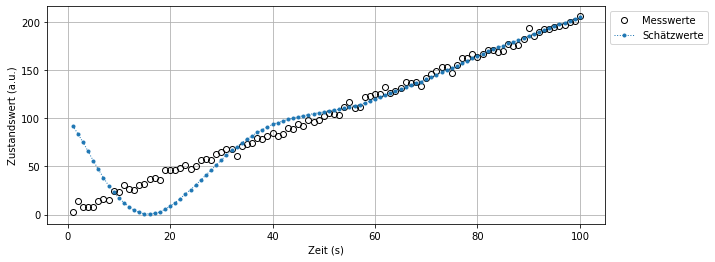

In [6]:
measurements = gen_data(x0=5., dx=2., num_data=100, st_dev=3)
filtered_data = g_h_filter(data=measurements, x0=100., dx0=2., dt=1., g=0.1, h=0.02)
plot_x_est(measurements, filtered_data)

Obwohl der Startwert satte 95 vom wahren ersten Wert entfernt ist, benötigt der Filter nur etwa 10 s, bis er "in der Spur" ist. Deutlich sichtbar ist aber auch ein Einschwingverhalten des g-h-Filters: Zwischen den Zeiten 10 und 25 s nähert sich der Filter von unten an den wahren Messwertverlauf an.  
Wenn die Standardabweichung der Messwerte auf 1 reduziert wird, kann man sogar beobachten, wie der Filter ab 25 s noch etwas um den wahren Verlauf des Zustandswertes hin und her oszilliert.

### g-h-Filter bei extrem verrauschten Messwerten
Die Simulation wird nun mit einer sehr viel höheren Standardabweichung von 100, dafür aber mit dem korrekten Startwert von 5 wiederholt. Dies soll die Wirkung des Filters bei stark verrauschten Messwerten verdeutlichen.

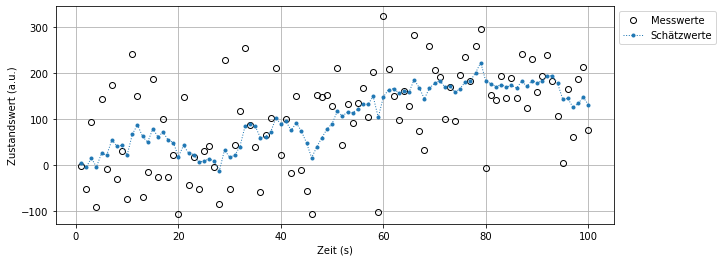

In [7]:
measurements = gen_data(x0=5., dx=2., num_data=100, st_dev=100)
filtered_data = g_h_filter(data=measurements, x0=5., dx0=2., g=0.2, h=0.02, dt=1.)
plot_x_est(measurements, filtered_data)

Bei diesem **extremen Rauschen ist der Filter an seine Grenzen geraten**: Die Schätzwerte rauschen zwar weniger als die Messwerte, jedoch lässt sich aus ihnen niemals ein linearer Anstieg um 2 pro Sekunde oder ein Startwert von 5 herauslesen.  Auf das Beispiel des Roboterfahrzeugs bezogen ließe sich nicht einmal eine verlässliche Aussage darüber machen ob es sich zur Wand hin oder von der Wand weg bewegt. Auch die Angabe eines verlässlichen Abstandswerts zur Wand ist hier nicht mehr möglich.

In diesem Beispiel handelt es sich ja "nur" um einen g-h-Filter. Ein Kalman-Filter, der weiß, dass das Messrauschen normalverteilt ist  und dessen Standardabweichung kennt, kann aus diesen Messdaten tatsächlich eine fast gerade Linie "herausfiltern". Dazu später in den entsprechenden Jupyter-Notebooks mehr.

### Quadratischer Messwertverlauf: Erzeugung von Messwerten und Reaktion des g-h-Filters
Die Erzeugungsfunktion `gen_data()` wird nun so erweitert, dass die Zustandsvariable nicht nur linear sondern auch quadratisch mit dem Vorfaktor `ddx` von der Zeit abhängt. Dem entspricht ein Bewegungsverlauf des Roboterfahrzeugs wie in der Skizze unten dargestellt.

<img src="RoboFahrzeugKurve.png" width="400">

Anschießend wird damit ein rauschfreier Messwerteverlauf über 20 Datenpunkte mit ``x0=0``, ``dx=0``, ``ddx=2`` simuliert. Im letzten Schritt werden diese Messdaten mit der g-h-Filter-Funktion `g_h_filter()` (``g=0.2``, ``h=0.02``) gefiltert und in einem Plot dargestellt.

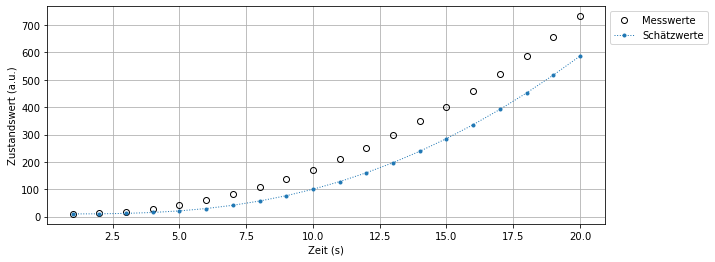

In [8]:
def gen_data(x0, dx, num_data, st_dev, ddx=0.):
    # dx: linear coefficient, ddx: quadratic coefficient
    return [x0 + dx*i + ddx*i**2 + randn()*st_dev for i in range(num_data)]
   
measurements = gen_data(x0=10., dx=0., num_data=20, st_dev=0, ddx=2.)
filtered_data = g_h_filter(data=measurements, x0=10., dx0=0., g=0.2, h=0.02, dt=1.)
plot_x_est(measurements, filtered_data)

Nun enttäuscht der Filter: Die Schätzwerte liegen ständig unter den Messdaten, welche aufgrund des fehlenden Rauschens identisch zu den Zustandswerten sind. Dies ist nicht verwunderlich, denn der g-h-Filter basiert auf einem physikalischen Modell, das keine Beschleunigung kennt. Er berechnet die Ableitung des Zustandswerts $\dot{x}$ und passt diese an unter der Annahme, die zweite Ableitung $\ddot{x}$ sei Null. Im nächsten Iterationsschritt steigt $\dot{x}$ aber weiter. Daher hinkt der Filter immer hinterher.  

**Dieses Problem lässt sich nicht durch eine geeignete Wahl von $g$ oder $h$ lösen** 

> Der Filter kann nur so gut sein wie das physikalische Modell im Hintergrund, welches das System beschreibt.

Für das Beispiel mit dem Roboterfahrzeug heißt dies konkret: Wenn das Fahrzeug in einer Kurve von der Wand weg bewegt, dann nützt kein Filter etwas, in dessen physikalischem Modell nur geradlinige Bewegungen vorkommen.

## Einfluss der Skalierungsfaktoren $g$ und $h$ auf die Filterwirkung
Unter nicht so feindlichen Umgebungsbedingungen wie oben lässt sich durch eine geschickte Wahl der Skalierungsfaktoren $g$ und $h$ eine sehr gute Wirkung des Filters erreichen.
### Linearer Messwertverlauf: Isolierter Einfluss des Skalierungsfaktors $g$
Zurück zu einem simulierten Messwerteverlauf *ohne* quadratische Abstandsänderung.  
$g$ ist der Skalierungsfaktor, welcher entscheidet, ob der Korrekturwert (nächster Schätzwert) näher am aktuellen Messwert oder am Vorhersagewert liegt.  
Im folgenden Code wird eine Messreihe mit 50 Messwerten erzeugt für `x0=5`, `dx=5`, `std_dev=50` sowie  `ddx=0`. Auf diese Simulationsdaten wird ein g-h-Filter mit ``g=0.1``, ``g=0.4`` und ``g=0.8`` angewendet. Der Skalierungsfaktor $h$ ist für jedes $g$ gleich 0.01. Für den Startwert gilt ``x0=0``.  
Im folgenden Plot des Mess- und Filterwerteverlaufs lässt sich Filterwirkung vergleichen.

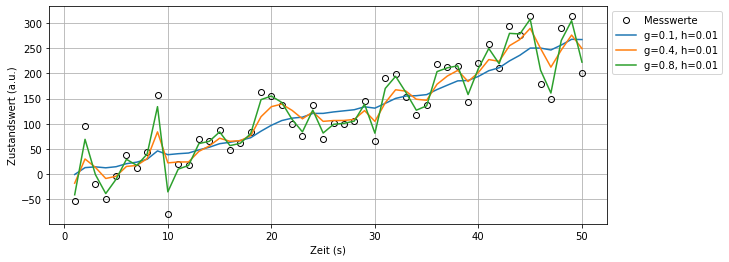

In [9]:
measurements = gen_data(x0=5., dx=5., num_data=50, st_dev=50, ddx=0)
filtered_data_1 = g_h_filter(data=measurements, x0=0., dx0=5., dt=1., g=0.1, h=0.01)
filtered_data_2 = g_h_filter(data=measurements, x0=0., dx0=5., dt=1., g=0.4, h=0.01)
filtered_data_3 = g_h_filter(data=measurements, x0=0., dx0=5., dt=1., g=0.8, h=0.01)

plt.figure(figsize=(10,4))
n = len(measurements)
time = range(1,n+1)
var, = plt.plot(time, measurements, color='k', mfc='None', marker = 'o', linestyle='None', label='Messwerte')
est1, = plt.plot(time, filtered_data_1, color = 'C0', label='g=0.1, h=0.01')
est2, = plt.plot(time, filtered_data_2, color = 'C1', label='g=0.4, h=0.01')
est3, = plt.plot(time, filtered_data_3, color = 'C2', label='g=0.8, h=0.01')
plt.legend(loc="upper left", bbox_to_anchor=(1,1))
plt.xlabel('Zeit (s)')
plt.ylabel('Zustandswert (a.u.)')
plt.grid()

Je größer $g$ ist, desto mehr folgt der Filter den Messwerten im Vergleich zu den Vorhersagewerten. Für ``g=0.8`` folgt der Filter schon fast nur noch den Messwerten, d.h. das Rauschen der Messwerte wird durch den Filter nicht wesentlich reduziert.  
Ganz anders sieht die Lage aus für ``g=0.1``: Das Messwertrauschen wird wie bei einem Tiefpassfilter wesentlich reduziert, da den Vorhersagewerten mehr Gewicht zugesprochen wird als den verrauschten Messwerten.  

### Nicht linearer Messwertverlauf mit Sättigung: Erzeugung von Messwerten und Reaktion des g-h-Filters
Wenn der Zustandswert brav linear ansteigt, dann wäre ein kleines $g$ bestimmt eine gute Wahl. In der Realität ist es aber oft so, dass der Verlauf der Zustandswerte sich abrupt ändern kann: Beispielsweise fährt das Roboterfahrzeug zurerst gerade aus in einem festen Winkel von der Wand weg. Dann kommt es an eine Ecke, an der die Wand plötzlich etwas "zu ihm hin knickt". Ab diesem Zeitpunkt fährt das Farzeug immer noch geradlinig in die gleiche Richtung, nun aber parallel zur Wand, siehe Skizze.

<img src="RoboFahrzeug15GradKnick.png" width="400">

Nachfolgend wird ein Verlauf des Zustandswerts untersucht, für den während der ersten 20 Sekunden $\dot{x}=1$ und anschließend $\dot{x}=0$ gilt. Die Messwerte bilden diesen Werteverlauf mit einer Standardabweichung von 1 ab. Dem g-h-Filter werden als Startwerte ein etwas zu kleines ``x0`` sowie das korrekte ``dx0`` für die anfängliche Abstandsänderung mitgegeben.  
Zuerst kommen drei willkürlich testweise gewähle Werte für $g$ und $h$ zur Anwendung.

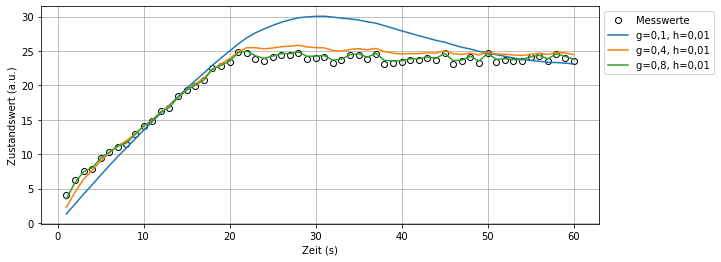

In [10]:
state_var = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14,15,16,17,18,19,20,21,22,23,24]
for i in range(40):
    state_var.append(24)

np.random.seed(100) #makes the random numbers predictable for reproducible simulations    
measurements = [value + randn()*0.5 for value in state_var] # adding noise
    
filtered_data_1 = g_h_filter(data=measurements, x0=0., dx0=1., dt=1., g=0.1, h=0.01)
filtered_data_2 = g_h_filter(data=measurements, x0=0., dx0=1., dt=1., g=0.4, h=0.01)
filtered_data_3 = g_h_filter(data=measurements, x0=0., dx0=1., dt=1., g=0.8, h=0.01)

plt.figure(figsize=(10,4))
n = len(measurements)
time = range(1,n+1)
var, = plt.plot(time, measurements, color='k', mfc='None', marker = 'o', linestyle='None', label='Messwerte')
est1, = plt.plot(time, filtered_data_1, color = 'C0', label='g=0,1, h=0,01')
est2, = plt.plot(time, filtered_data_2, color = 'C1', label='g=0,4, h=0,01')
est3, = plt.plot(time, filtered_data_3, color = 'C2', label='g=0,8, h=0,01')
plt.legend(loc="upper left", bbox_to_anchor=(1,1))
plt.xlabel('Zeit (s)')
plt.ylabel('Zustandswert (a.u.)')
plt.grid()

Der Filter mit ``g=0.1`` ignoriert praktisch die Messwerte und verlässt sich im Wesentlichen auf das Modell: Er braucht recht lange, bis der Fehler durch den um 5 zu klein angenommen Startwert "ausgebügelt" ist. Nach dem Knick bei t = 20 s braucht dieser Filter wieder recht lange, bis er die reale Situation erkannt hat.  

Der Filter mit ``g=0.8`` macht eigentlich gute Arbeit, was das Folgen des Signalverlaufs im Groben betrifft. Er reduziert jedoch das Messwertrauschen nur unzulänglich.  

Der Filter mit ``g=0.4`` ist kein wirklicher Kompromiss, da er während des Plateaus ständig oberhalb der Messwerte liegt.  

**Das geht besser, wenn man *beide* Skalierungsfaktoren optimal wählt:** Nachfolgend sind zwei Kombinationen von $g$ und $h$ als Filterverlauf dargestellt, die die Knickstelle ähnlich gut meistern wie die Kurve für ``g=0.8`` gleichzeitig das Rauschen aber besser reduzieren.

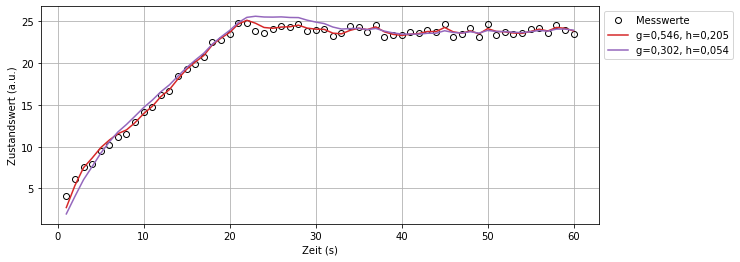

In [11]:
state_var = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14,15,16,17,18,19,20,21,22,23,24]
for i in range(40):
    state_var.append(24)

np.random.seed(100) #makes the random numbers predictable for reproducible simulations  
measurements = [value + randn()*0.5 for value in state_var] # adding noise

filtered_data_4 = g_h_filter(data=measurements, x0=0., dx0=1., dt=1., g=0.546, h=0.205)
filtered_data_5 = g_h_filter(data=measurements, x0=0., dx0=1., dt=1., g=0.302, h=0.054)

plt.figure(figsize=(10,4))
n = len(measurements)
time = range(1,n+1)
var, = plt.plot(time, measurements, color='k', mfc='None', marker = 'o', linestyle='None', label='Messwerte')
est4, = plt.plot(time, filtered_data_4, color = 'C3', label='g=0,546, h=0,205')
est5, = plt.plot(time, filtered_data_5, color = 'C4', label='g=0,302, h=0,054')
plt.legend(loc="upper left", bbox_to_anchor=(1,1))
plt.xlabel('Zeit (s)')
plt.ylabel('Zustandswert (a.u.)')
plt.grid()

Beim Vergleich der Filterkurven für ``g=0.4 h=0.01`` im vorletzten und für ``g=0.302 h=0.054`` im obigen Plot muss genau hingeschaut werden:  
Erstere Kurve braucht fast 40 s bis sie auf dem Plateau nicht oberhalb sondern wieder zwischen den Messwerten verläuft.
Letztere Kurve folgt nach einem kurzen Überschwinger schon nach ca. 7 Sekunden wieder den Messwerten.  
Um beide Plots vergleichen zu können, wurde übrigens die Funktion `random.seed(100)` des ``NumPy`` Packages verwendet. Dadurch wird für beide Plots die selbe Zufallszahlenfolge generiert, d.h. die Ergebnisse sind reproduzierbar und direkt vergleichbar.

### Isolierter Einfluss des Skalierungsfaktors $h$
Nun soll untersucht werden, welchen Einfluss der Skalierungsfaktor $h$ bei konstant gehaltenem Skalierungsfaktor $g$ hat.  
Im Plot oben wurde schon dargestellt, dass ein größeres $h$ den Filter der Knickstelle besser folgen lässt.  
$h$ bestimmt, wie viel Einfluss die *Änderungsrate*  $\dot{x}$ der Messwerte auf die Vorhersage hat. Wenn die Messwerte sich rasch im Vergleich zu der Samplingzeit ändern, dann bewirkt ein größeres $h$ ein schnelleres Reagieren des Filters. Ein kleineres $h$ macht den Filter träger.

Die Beispielmessdaten im Plot steigen linear um 1 pro Sekunde an und sind etwas verrauscht. Alle Filter verwenden den richtigen Startwert. Nur der erste Filter jedoch verwendet auch den richtigen Startwert für die Zustandsänderung.  
Der zweite und dritte Filter verwendet einen zweifach zu hohen Startwert für die Zustandsänderung: Dies führt zu einen deutlichen Überschwingen. Hier ändert sich durch den Skalierungsfaktor $h$ sowohl die Amplitude als auch die Frequenz des Überschwingens.  
**D.h. durch eine gute Wahl des Skalierungsfaktors h lässt sich bei Sprüngen im Messwertverlauf das Einschwingverhalten des Filters optimieren.**

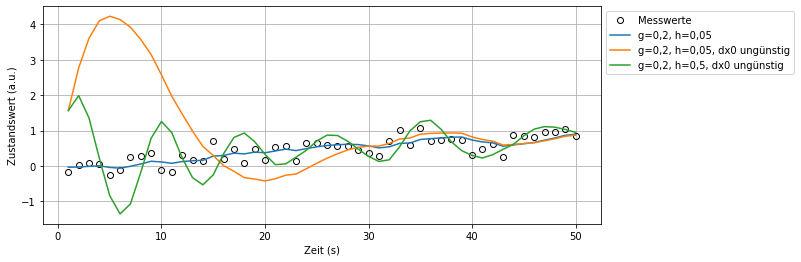

In [12]:
state_var = np.linspace(0, 1, 50)
measurements = [value + randn()*0.2 for value in state_var] # adding noise

filtered_data_1 = g_h_filter(data=measurements, x0=0., dx0=0., dt=1., g=0.2, h=0.05)
filtered_data_2 = g_h_filter(data=measurements, x0=0., dx0=2., dt=1., g=0.2, h=0.05)
filtered_data_3 = g_h_filter(data=measurements, x0=0., dx0=2., dt=1., g=0.2, h=0.5)

plt.figure(figsize=(10,4))
n = len(measurements)
time = range(1,n+1)
var, = plt.plot(time, measurements, color='k', mfc='None', marker = 'o', linestyle='None', label='Messwerte')
est1, = plt.plot(time, filtered_data_1, color = 'C0', label='g=0,2, h=0,05')
est2, = plt.plot(time, filtered_data_2, color = 'C1', label='g=0,2, h=0,05, dx0 ungünstig')
est3, = plt.plot(time, filtered_data_3, color = 'C2', label='g=0,2, h=0,5, dx0 ungünstig')
plt.legend(loc="upper left", bbox_to_anchor=(1,1))
plt.xlabel('Zeit (s)')
plt.ylabel('Zustandswert (a.u.)')
plt.grid()

## Vergleich g-h-Filter mit gleitender Mittelwertbildung
Spätestens jetzt muss die Frage gestellt werden, ob es die ganze Arbeit zum g-h-Filter überhaupt wert war. **Ist ein g-h-Filter in dieser Basisvariante wirklich schon besser als ein Filter mit gleitender Mittelwertbildung?**  

Angenommen, das Roboterfahrzeug sei exakt parallel zur Wand ausgerichtet und fährt geradlinig im konstanten Abstand parallel zur Wand. In diesem Fall ist es egal, ob man die stark streuenden Abstandsmesswert einfach gleitend mittelt oder einen g-h-Filter verwendet. Beim g-h-Filter wäre ein großer Skalierungsfaktor $g$ und kleiner Skalierungsfaktor $h$ hierfür optimal geeignet.  

### Gleitender Mittelwert im Vergleich zum g-h-Filter bei unstetigem Messwertverlauf

Was passiert aber, wenn das Fahrzeug an einer Wandnische wie unten skizziert vorbei kommt?

<img src="RoboFahrzeugNische.png" width="400">

#### Erzeugung von Messwerten und Reaktion des g-h-Filters für unstetigen Messwertverlauf
Der nachfolgende Quellcode erstellt Messwertreihe von Abstandswerten über 100 Sekunden. Die 50 mm tiefe Wandnische befindet sich im Zeitraum zwischen 35 und 65 Sekunden.  

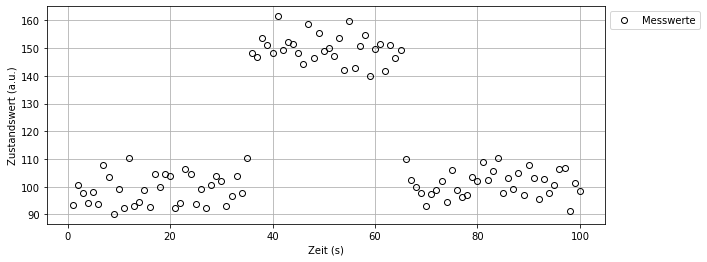

In [13]:
state_var = []
for i in range(35):
    state_var.append(100)
for i in range(30):
    state_var.append(150)
for i in range(35):
    state_var.append(100)
    
measurements = [value + randn()*5 for value in state_var] # adding noise
plt.figure(figsize=(10,4))
n = len(measurements)
time = range(1,n+1)
var, = plt.plot(time, measurements, color='k', mfc='None', marker = 'o', linestyle='None', label='Messwerte')

plt.legend(loc="upper left", bbox_to_anchor=(1,1))
plt.xlabel('Zeit (s)')
plt.ylabel('Zustandswert (a.u.)')
plt.grid()

#### Gleitender-Mittelwert-Filter bei unstetigem Messwertverlauf
Für die Simulation einer gleitenden Mittelwertbildung wird die Faltungs-Funktion `convolve()` aus dem ``NumPy`` Package verwendet.  
Mathematisch ist die $N$-fache gleitende Mittelwertbildung eine Faltung mit einem Rechteck der Breite $N$. Der Aufpunkt zur Zeit $t$ wird mit einem Rechteck der Breite $T = N \cdot \Delta T$ gefaltet, wobei $\Delta T$ für die Abtastzeit steht. Dies bedeutet, dass sich der gemittelte Sensorwert zur Zeit $t$ aus dem ursprünglichen Sensorwert und den $N-1$ nachfolgenden Sensorwerten zusammensetzt.  
Bei Sensorwerten macht dies keinen Sinn, da der aktuelle Sensorwert nur mit vorhergehenden und nicht mit zukünftigen Sensorwerten gemittelt werden kann.  
Daher wird im nachfolgenden Quellcode die Zeitachse für das Faltungsergebnis einfach um $N-1$ Abtastzeiten nach links (in die Vergangenheit) verschoben.


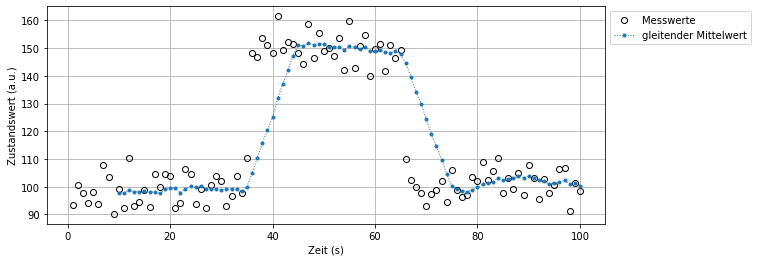

In [14]:
num_ave = 10
float_ave = np.convolve(measurements, np.ones((num_ave,))/num_ave, mode='valid')

plt.figure(figsize=(10,4))
n = len(measurements)
time = range(1,n+1)
var, = plt.plot(time, measurements, color='k', mfc='None', marker = 'o', linestyle='None', label='Messwerte')
fl_ave, = plt.plot(time[num_ave-1:n], float_ave, marker = 'o', linestyle=':', linewidth = 1, markersize=3, 
                   label='gleitender Mittelwert')

plt.legend(loc="upper left", bbox_to_anchor=(1,1))
plt.xlabel('Zeit (s)')
plt.ylabel('Zustandswert (a.u.)')
plt.grid()

Es ist sehr gut sichtbar, wie die gleitende Mittelwertbildung das Rauschen der Messwerte erheblich reduziert. Allerdings verursacht es einen erheblichen Zeitversatz des gefilterten Signals: Erst nach 10 Sekunden erreicht der Mittelwert den korrekten Abstandswert für die Wandnische. Das ist nachvollziehbar, denn es braucht ja 10 korrekte Werte für die Mittelwertbildung.  
**Zudem ist offensichtlich, dass der Filter während der ersten 10 Sekunden keinen Wert ausgibt, da während dieser Zeit noch kein 10-fach Mittelwert vorliegt.**

**Frage**: Ist dieser Mittelwertfilter nicht auch eine Spezialform eines g-h-Filters?  
**Antwort**: Der Vorhersagewert ist der Mittelwert der letzten neun "Messwerte" - *nicht* "Schätzwerte". Der neue zehnte Messwert korrigiert diesen Vorhersagewert, in dem ein gewichteter Mittelwert aus 90 % Vorhersagewert und 10 % Messwert berechnet wird. Insofern ist dieser Filter einem g-h-Filter ähnlich, aber ihm liegt kein physikalisches Modell zugrunde und er verwendet auch nicht den letzten Schätzwert für eine Vorhersage.  

#### gh-Filter bei unstetigem Messwertverlauf
Statt des Mittelwertfilters wird nachfolgend ein optimierter g-h-Filter angewendet, der die Messdaten ohne größeren Zeitversatz ähnlich gut glättet.

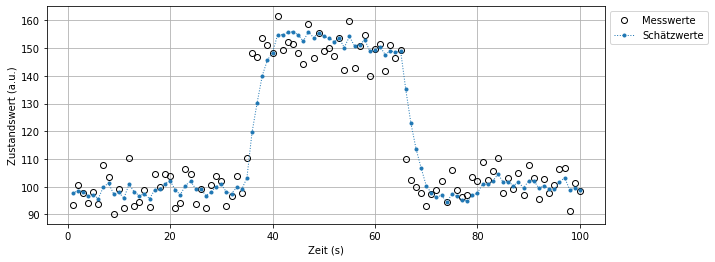

In [15]:
filtered_data = g_h_filter(data=measurements, x0=100., dx0=0, dt=1., g=0.360, h=0.025)
plot_x_est(measurements, filtered_data)

Es ist recht mühsam, die optimalen Parameter des g-h-Filters zu finden. Die Startwerte für den Abstand und die Abstandsänderung spielen hier eine untergeordnete Rolle, weil 35 Sekunden Zeit ist, um den Filter in die Spur zu bekommen.  
Dafür, wie gut der Filter der Wandnische folgt, sind allein die Parameter $g$ und $h$ verantwortlich:  Man muss $g$ klein genug wählen, damit die Rauschreduktion nicht zu schlecht wird. Ein zu großes $g$ lässt die Schätzwerte genau so stark rauschen wie die Messwerte, was den Filter überflüssig macht.  
Falls $h$ zu groß ist, dann zeigt sich ein deutliches Überschwingen an den Ecken der Nische. Ist $h$ zu klein, dann hat der Filter eine zu lange Einschwingzeit an den Nischenecken.  
Eine gute Wahl von $g$ und $h$ für diesen speziellen Messwerteverlauf ist wie im Plot dargestellt 0,36 bzw. 0,025, wie sich (nur) durch Ausprobieren herausfinden lässt.

### Gleitender Mittelwert im Vergleich zu g-h-Filter bei linearem Messwerteverlauf
Das Problem der Signalverzögerung durch eine gleitende Mittelwertbildung tritt auch bei einem linearen Messwerteverauf auf. Hier zeigt sich der Vorteil des g-h-Filter noch augenscheinlicher, da er ja hierfür das optimale physikalische Modell besitzt.  
In folgendem Plot ist die Wirkung beider Filter verglichen.

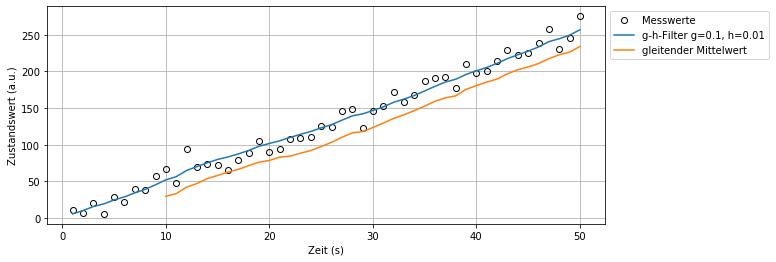

In [16]:
measurements = gen_data(x0=5., dx=5., num_data=50, st_dev=10, ddx=0)
gh_filtered_data = g_h_filter(data=measurements, x0=0., dx0=5., dt=1., g=0.1, h=0.01)

num_ave = 10
float_ave = np.convolve(measurements, np.ones((num_ave,))/num_ave, mode='valid')

plt.figure(figsize=(10,4))
n = len(measurements)
time = range(1,n+1)
var, = plt.plot(time, measurements, color='k', mfc='None', marker = 'o', linestyle='None', label='Messwerte')
est1, = plt.plot(time, gh_filtered_data, color = 'C0', label='g-h-Filter g=0.1, h=0.01')
est2, = plt.plot(time[num_ave-1:n], float_ave, color = 'C1', label='gleitender Mittelwert')
plt.legend(loc="upper left", bbox_to_anchor=(1,1))
plt.xlabel('Zeit (s)')
plt.ylabel('Zustandswert (a.u.)')
plt.grid()

Die gleitende Mittelwertbildung hat also nicht nur den Nachteil, dass erst einmal 10 Sensorwerte vorliegen müssen, bis der Filter seinen ersten Output liefert. Das gefilterte Signal ist zudem stark zeitverzögert. Dies ist keine gute Idee, wenn ein System schnell auf Sensormessdaten reagieren soll.

## Zusammenfassung und Schlussbemerkung

Der Sinn und Zweck dieses Jupyter-Notebooks ist die Möglichkeit, mit den verschiedenen Filtern darin zu spielen: So kann untersucht werden, wie sich das Ausmaß des Rauschens oder die beiden Skalierungsfaktoren auf die Güte des Filters auswirken.  
> Solche Filter für Sensormessdaten *muss* man via Trail-And-Error optimieren. Filter werden *entwickelt* und nicht im Elfenbeinturm *erdacht*.

Das Thema "g-h-Filter" wird hiermit beendet. Es diente nur der Vorbereitung auf den Kalman-Filter. Was bisher noch fehlt, ist das Einfließen von Statistikberechnungen wie beispielsweise kombinierte Wahrscheinlichkeiten. Genau dies erfolgt mit dem Kalman-Filter und ist Thema im folgenden Jupyter-Notebook, in dem es um Bayes-Filter geht.  
Das Thema "g-h-Filter" wird hiermit beendet. Es diente nur der Vorbereitung auf den Kalman-Filter.